In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as spst
import scipy.special as spsp
import stats as pst
from scipy.integrate import quad as integral

In [2]:
def comlicate_chi_squared_test_poisson(path, alpha):
    fb_stats = pd.read_csv(path)
    goals_sample = np.zeros(fb_stats.shape[0])
    for i in range(fb_stats.shape[0]):
        goals_sample[i] = fb_stats['FTHG'].iloc[i] + fb_stats['FTAG'].iloc[i]
    N = len(set(goals_sample))
    frec2goal = {}
    for el in goals_sample:
        if el not in frec2goal:
            frec2goal[el] = 0
        frec2goal[el] += 1
    n = goals_sample.shape[0]
    x_mean = np.mean(goals_sample)
    p = np.zeros(N)
    j=0
    for i in list(set(goals_sample)):
        p[j] = pst.PoissonDistribution(x_mean, [i])
        j+=1
    S = 0
    for i in range(N):
        S += (frec2goal[i]-n*p[i])**2/(n*p[i])
    print(S <= spst.chi2.isf(alpha, N-1))

In [3]:
comlicate_chi_squared_test_poisson('goals1819.csv', 0.005)

True


# Простые гипотезы о виде распределения

## Критерий согласия Колмогорова-Смирнова (с поправкой Большева)
$ D_n = max(D_n^{+}, D_n^-) $

$ D_n^+=\max_{1\leqslant k\leqslant n}\left( \frac{k}{n}-F(X_{(k)}) \right), \quad D_n^-=\max_{1\leqslant k\leqslant n}\left( F(X_{(k)})-\frac{k-1}{n} \right) $

$ S=\frac{6nD_n+1}{6\sqrt{n}} $ - поправка Большева

In [4]:
def simple_kolmogorov_test(sample, alpha, mu, m, pic_path, text_path):
    sort_sample = np.sort(sample)
    n = sort_sample.shape[0]
    Dn_plus = 0
    Dn_minus = 0
    for k in range(sort_sample.shape[0]):
        if (k/n-spsp.gdtr(mu, m, sort_sample[k]))>Dn_plus:
            Dn_plus = k/n-spsp.gdtr(mu, m, sort_sample[k])
        if (spsp.gdtr(mu, m, sort_sample[k])-(k-1)/n)>Dn_minus:
            Dn_minus = (spsp.gdtr(mu, m, sort_sample[k])-(k-1)/n)
    Dn = np.max((Dn_plus, Dn_minus))
    S_Bolshev = (6*n*Dn+1)/(6*np.sqrt(n))
    file = open(text_path, 'w')
    for al in alpha:
        if S_Bolshev < spst.kstwobign.ppf(1-al):
            decision = 'accepts'
        else:
            decision = 'rejects'
        print('S_Bolshev = {} < {} and K-S test {} with alpha={}'.format(S_Bolshev, spst.kstwobign.ppf(1-al), decision, al))
        file.write("S_Bolshev = {0} < {1} and K-S test {2} with alpha={3}\n".format(S_Bolshev, spst.kstwobign.ppf(1-al), decision, al))
    file.close()
    X_e, Y_e = pst.emperical_erlang(sort_sample, 1)
    plt.figure(figsize=(10, 7));
    plt.step(X_e, Y_e, where='post', label='Sample');
    plt.plot(X_e, spsp.gdtr(mu, m, X_e), label='Erlang CDF');
    plt.grid();
    plt.legend();
    plt.savefig(pic_path);
    

S_Bolshev = 1.064432117481404 < 1.2238478702170825 and K-S test accepts with alpha=0.1
S_Bolshev = 1.064432117481404 < 1.3580986393225505 and K-S test accepts with alpha=0.05


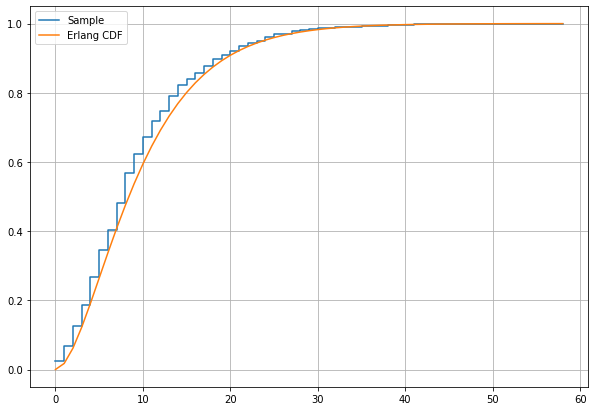

In [5]:
mu = 0.2
m = 2
n = 1000
alpha = [0.1, 0.05]
erlang_sample_for_KSTest = pst.random_erlang(m, mu, n)
simple_kolmogorov_test(erlang_sample_for_KSTest, alpha, mu, m, 'Images/Simple_KS_Test.pdf', 'Text/Simple_KS_Test.txt')

## Критерий согласия $ \chi^2 $

In [6]:
def simple_chi_square_test(sample, params, distribution, c_e_p, alpha, pic_path, text_path):
    '''
    params - array-like with 1 or 2 parameters (m, theta)
    distribution - function with pdf of distribution
    c_e_p - count of estemated parameters
    '''
    if distribution == 'poisson':
        X_points = np.array(np.sort(list(set(sample))), dtype='float32')
        N = len(X_points)
        freq = {}
        for point in sample:
            if point not in freq:
                freq[point] = 0
            freq[point]+=1
        n = np.sum(list(freq.values()))
        p = np.zeros(N)
        i = 0
        for point in X_points:
            p[i] = pst.PoissonDistribution(params[0], [point])
            i += 1
        S = 0
        for i in range(N):
            S += (freq[X_points[i]]-n*p[i])**2/(n*p[i])
        file = open(text_path, 'w')
        for al in alpha:
            if S <= spst.chi2.ppf(1-al, N-1-c_e_p): decision = 'accepts'
            else: decision = 'rejects'
            print('S = {} <= {} and Chi2 test {} with alpha={}'.format(S, spst.chi2.ppf(1-al, N-1-c_e_p), decision, al))
            file.write('S = {} <= {} and Chi2 test {} with alpha={}\n'.format(S, spst.chi2.ppf(1-al, N-1-c_e_p), decision, al))
        file.close()
        freq_sort = sorted(list(freq.items()), key=lambda x: x[0])
        X_ = np.zeros(len(freq_sort))
        Y_ = np.zeros_like(X_)
        for i in range(len(freq_sort)):
            X_[i] = freq_sort[i][0]
            Y_[i] = freq_sort[i][1]
        Y_ = Y_/n
        plt.figure(figsize=(10, 7));
        plt.plot(X_, Y_, color='orange', label='Sample');
        plt.scatter(X_, Y_, color='red');
        plt.plot(X_, pst.PoissonDistribution(params[0], X_), label='Poisson PDF');
        plt.grid();
        plt.legend();
        plt.savefig(pic_path);
        
        
    if distribution == 'erlang':
        X_points = np.array(np.sort(list(set(sample))), dtype='float32')
        Sturges_points = 1+int(np.log2(X_points.shape[0]))
        N = Sturges_points-1
        point_min = int(np.min(sample))
        point_max = int(np.max(sample))+1
        z = np.linspace(point_min, point_max, Sturges_points)
        intervals = np.array([(z[i],z[i+1]) for i in range(z.shape[0]-1)])
        p = np.zeros(intervals.shape[0])
        for i in range(p.shape[0]):
            p[i] = integral(lambda x: pst.Erlang_density(params[0], params[1], [x]), intervals[i][0], intervals[i][1])[0]
        freq = np.zeros_like(p)
        j = 0
        
        for interval in intervals:
            x1 = sample[sample<interval[1]]
            x2 = sample[sample>interval[0]]
            x = np.intersect1d(x1, x2, assume_unique=True)
            freq[j] = x.shape[0]
            j+=1
        n = np.sum(freq)
        S = 0
        for i in range(N):
            S += (freq[i]-n*p[i])**2/(n*p[i])
        file = open(text_path, 'w')
        for al in alpha:
            if S <= spst.chi2.ppf(1-al, N-1-c_e_p): decision = 'accepts'
            else: decision = 'rejects'
            print('S = {} <= {} and Chi2 test {} with alpha={}'.format(S, spst.chi2.ppf(1-al, N-1-c_e_p), decision, al))
            file.write('S = {} <= {} and Chi2 test {} with alpha={}\n'.format(S, spst.chi2.ppf(1-al, N-1-c_e_p), decision, al))
        file.close()
        X, Y = pst.hist_freq(sample, intervals[0][1])
        plt.figure(figsize=(10, 7));
        plt.bar(X, Y, label='Sample');
        x = np.linspace(0, point_max, point_max+1)
        plt.plot(x, pst.Erlang_density(params[0],params[1],x), label='Erlang Density', color='red');
        plt.grid();
        plt.legend();
        plt.savefig(pic_path);

S = 9.32952003034001 <= 12.591587243743977 and Chi2 test accepts with alpha=0.05
S = 9.32952003034001 <= 10.644640675668422 and Chi2 test accepts with alpha=0.1


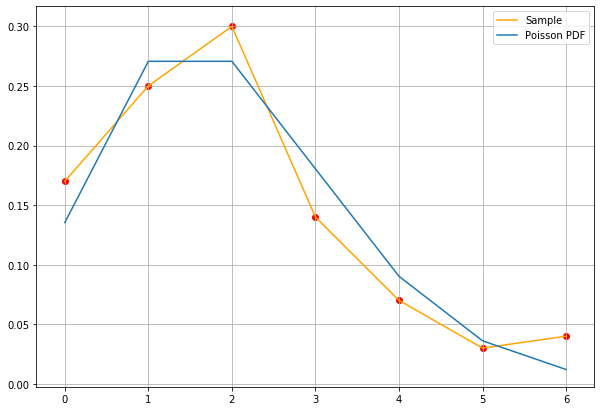

In [7]:
mu = 2
n = 100
params = [mu]
alpha_list = [0.05, 0.1]
poisson_sample_for_Chi2Test = pst.random_poisson(mu, n)
simple_chi_square_test(poisson_sample_for_Chi2Test, params, 'poisson', 0, alpha_list, 'Images/Simple_Chi2_Poisson.pdf', 'Text/Simple_Chi2_Poisson.txt')

S = 5.527258712276454 <= 15.50731305586545 and Chi2 test accepts with alpha=0.05
S = 5.527258712276454 <= 13.36156613651173 and Chi2 test accepts with alpha=0.1


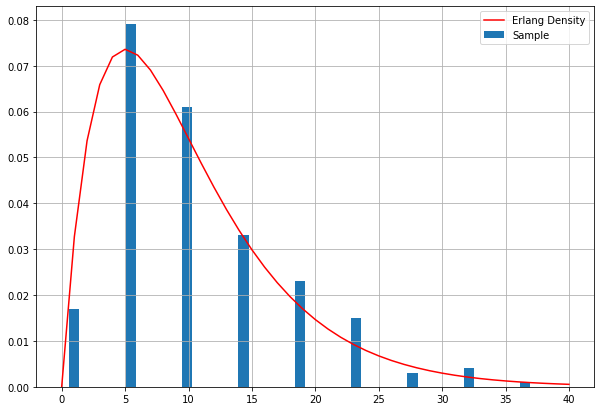

In [8]:
mu = 0.2
m = 2
n = 1000
params = [m, mu]
alpha_list = [0.05, 0.1]
erlang_sample_for_Chi2Test = pst.random_erlang(m, mu, n)
simple_chi_square_test(erlang_sample_for_Chi2Test, params, 'erlang', 0, alpha_list, 'Images/Simple_Chi2_Erlang.pdf', 'Text/Simple_Chi2_Erlang.txt')

# Сложные гипотезы
Будем делить выборку размера $n$ пополам (+-) на $ X_{est} $ и $ X_{test} $

По выборке $X_{est}$ будем оценивать параметр $\lambda$ методом максимального правдоподобия

ОМП для Пуассона: $\hat{\lambda} = \frac{1}{n}\sum\limits_{i=1}^{n}x_i = \overline{X}$

ОМП для Эрланга: $\hat{\lambda} = \frac{m}{\overline{X}}$

По выборке $X_{test}$ будем проверять критерии согласия с использованием полученных оценок

## Сложная гипотеза критерия Колмогорова-Смирнова (с поправкой Большева)

In [9]:
def complicated_KS_test(sample, alpha, m, pic_path, text_path):
    n = sample.shape[0]
    if n % 2 == 0:
        X_est = sample[:int(n/2)]
        X_test = sample[int(n/2):]
    else:
        X_est = sample[:int(n/2)]
        X_test = sample[int(n/2):]
    MLE = m/np.mean(X_est)
    simple_kolmogorov_test(X_test, alpha, MLE, m, pic_path, text_path)

S_Bolshev = 0.9483064237024541 < 1.3580986393225505 and K-S test accepts with alpha=0.05
S_Bolshev = 0.9483064237024541 < 1.2238478702170825 and K-S test accepts with alpha=0.1


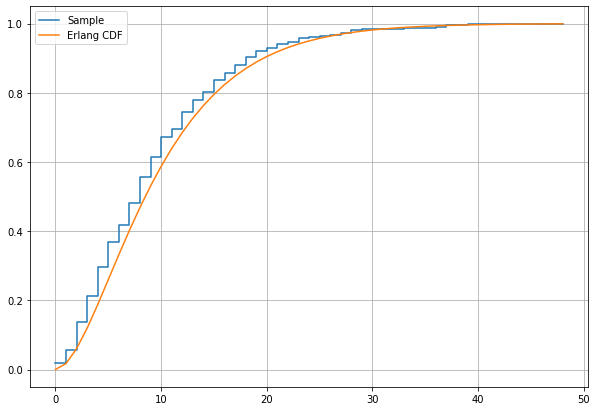

In [10]:
m = 2
mu = 0.2
n = 1000
alpha_list = [0.05, 0.1]
erlang_sample_for_complicated_KS_test = pst.random_erlang(m, mu, n)
complicated_KS_test(erlang_sample_for_complicated_KS_test, alpha_list, m, 'Images/Compl_KS_Test.pdf', 'Text/Compl_KS_Test.txt')

## Сложна гипотеза хи-квадрат

In [11]:
def complicated_chi2_test(sample, alpha, params, distribution, c_e_p, pic_path, text_path):
    n = sample.shape[0]
    if n % 2 == 0:
        X_est = sample[:int(n/2)]
        X_test = sample[int(n/2):]
    else:
        X_est = sample[:int(n/2)]
        X_test = sample[int(n/2):]
    if distribution == 'poisson':
        MLE = np.mean(X_test)
        params = [MLE]
    if distribution == 'erlang':
        MLE = params[0]/np.mean(X_test)
        params = [params[0], MLE]
    simple_chi_square_test(sample, params, distribution, c_e_p, alpha, pic_path, text_path)

S = 7.528579505480654 <= 14.067140449340169 and Chi2 test accepts with alpha=0.05
S = 7.528579505480654 <= 12.017036623780532 and Chi2 test accepts with alpha=0.1


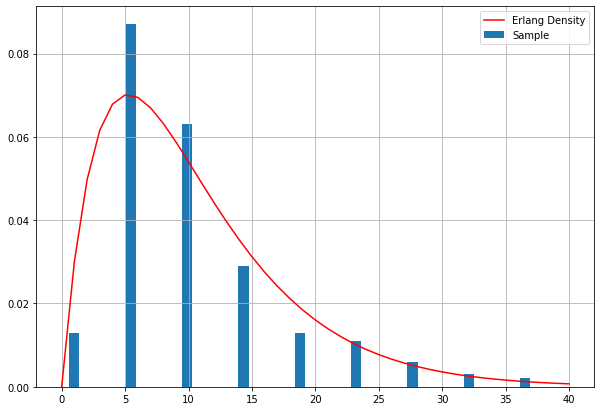

In [12]:
m = 2
mu = 0.2
n = 1000
alpha_list = [0.05, 0.1]
erlang_sample_for_complicated_Chi2_test = pst.random_erlang(m, mu, n)
complicated_chi2_test(erlang_sample_for_complicated_Chi2_test, alpha_list, [m , mu], 'erlang', 1, 'Images/Compl_C2_Erlang.pdf', 'Text/Compl_C2_Erlang.txt')

S = 1.9708909736466178 <= 12.591587243743977 and Chi2 test accepts with alpha=0.05
S = 1.9708909736466178 <= 10.644640675668422 and Chi2 test accepts with alpha=0.1


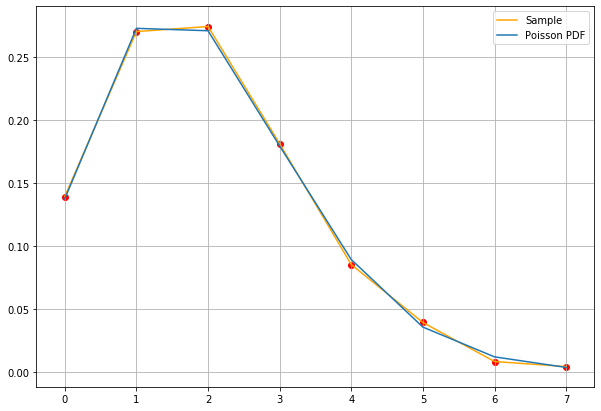

In [13]:
mu = 2
n = 1000
alpha_list = [0.05, 0.1]
poisson_sample_for_complicated_Chi2_test = pst.random_poisson(mu, n)
complicated_chi2_test(poisson_sample_for_complicated_Chi2_test, alpha_list, [mu], 'poisson', 1, 'Images/Compl_C2_Poisson.pdf', 'Text/Compl_C2_Poisson.txt')